In [173]:
import pandas as pd

#df1 = pd.read_excel("./data/anon_WMSPick20250101_03.xlsx") # Slechte data: timestamps kloppen niet
df2 = pd.read_excel("./data/anon_WMSPick20250104_06.xlsx")
df3 = pd.read_excel("./data/anon_WMSPick20250107_09.xlsx")
#df4 = pd.read_excel("./data/anon_WMSPick20250110_12.xlsx") # idem
df5 = pd.read_excel("./data/anon_WMSPick20250113_15.xlsx")
df6 = pd.read_excel("./data/anon_WMSPick20250116_19.xlsx")

dfs=[df2,df3,df5,df6]
df=pd.concat(dfs)

df['Creation Dt'] = pd.to_datetime(df['Creation Dt'].astype(float), origin='1899-12-30', unit='D')
df['Last Change Dt'] = pd.to_datetime(df['Last Change Dt'].astype(float), origin='1899-12-30', unit='D')

#print(df.dtypes)
#print(df.head())

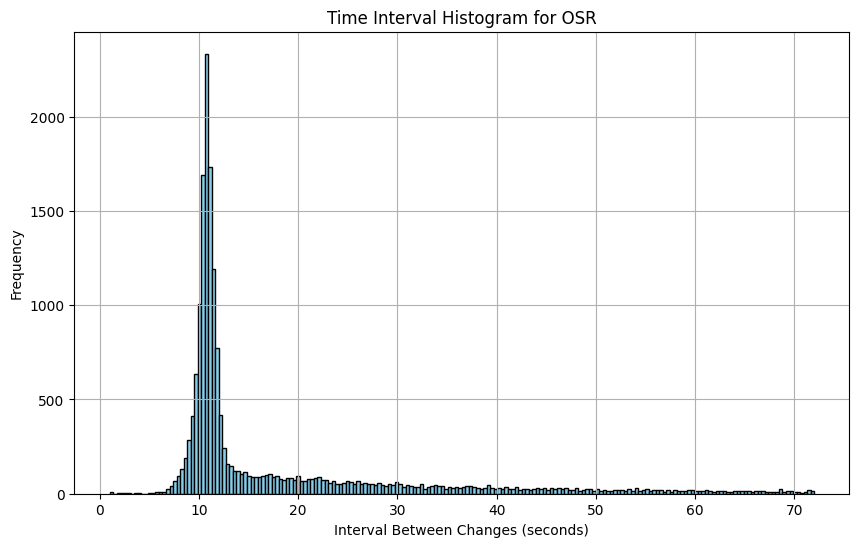

In [186]:
import matplotlib.pyplot as plt
loc = 'OSR'

# Step 1: Filter to just Picklist line number 1
loc_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

# Step 2: Compute time differences
loc_df['Time Delta'] = loc_df['Last Change Dt'].diff()

# Step 3: Convert to seconds for plotting
loc_df['Delta Seconds'] = loc_df['Time Delta'].dt.total_seconds()

# Calculate lower and upper bounds using quantiles
upper_bound = loc_df['Delta Seconds'].quantile(0.99)

# Filter out outliers
filtered_intervals = loc_df['Delta Seconds'][
    (loc_df['Delta Seconds'] <= upper_bound) &
    (loc_df['Delta Seconds'] >= 1)
]

# Step 4: Drop NaN (first diff will be NaN) and plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_intervals.dropna(), bins=200, color='skyblue', edgecolor='black')
plt.title('Time Interval Histogram for OSR')
plt.xlabel('Interval Between Changes (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Location code
OSR           172745
PTL-NEST14     10256
PTL-NEST12      9957
PTL-NEST26      9941
PTL-NEST21      9078
PTL-NEST23      9068
PTL-NEST13      8548
PTL-NEST15      7855
PTL-NEST16      7801
PTL-NEST25      7724
PTL-NEST24      7447
PTL-NEST11      7318
PTL-NEST22      7175
PACK            1712
BAK04C          1622
BAK04A          1585
BAK04B          1539
BAK04D          1308
BAK08B          1284
BAK08D          1116
Name: count, dtype: int64


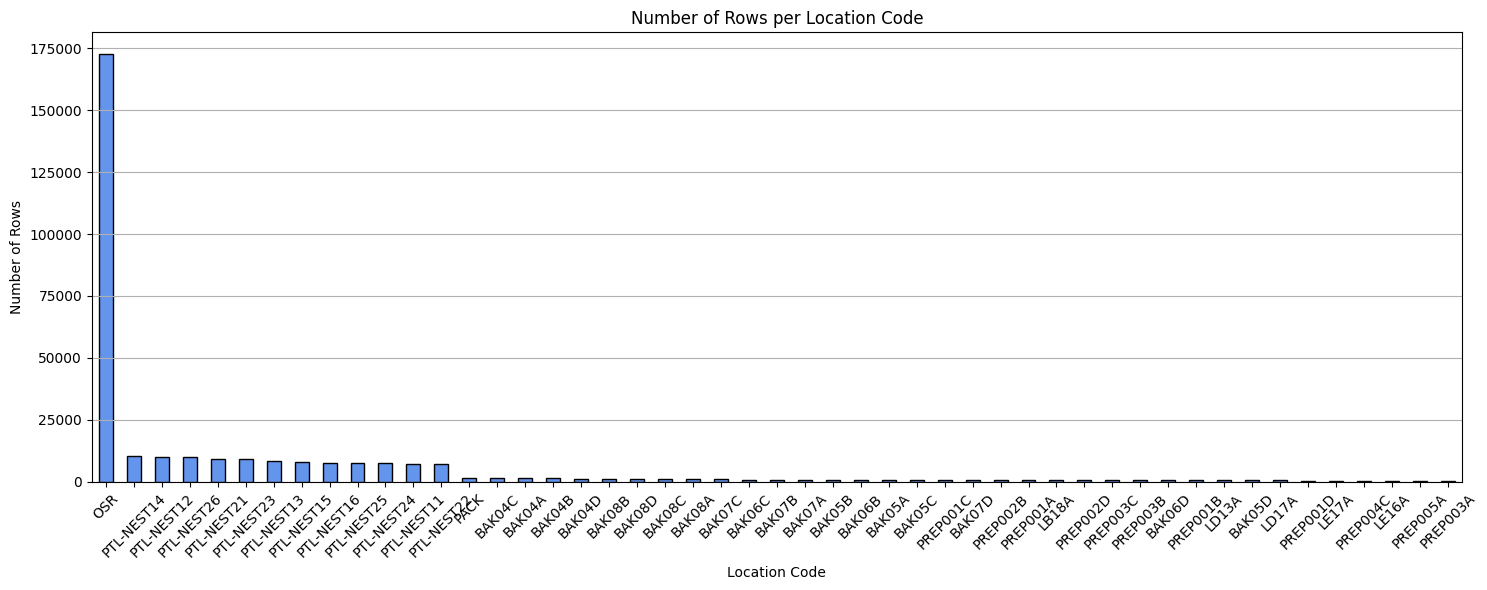

In [175]:
container_count = df['Location code'].value_counts()
container_count = container_count[container_count >= 500]  # Keep only counts ≥ 3

print(container_count.head(20))
# Step 2: Plot
plt.figure(figsize=(15, 6))
container_count.plot(kind='bar', color='cornflowerblue', edgecolor='black')

# Step 3: Beautify
plt.title('Number of Rows per Location Code')
plt.xlabel('Location Code')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

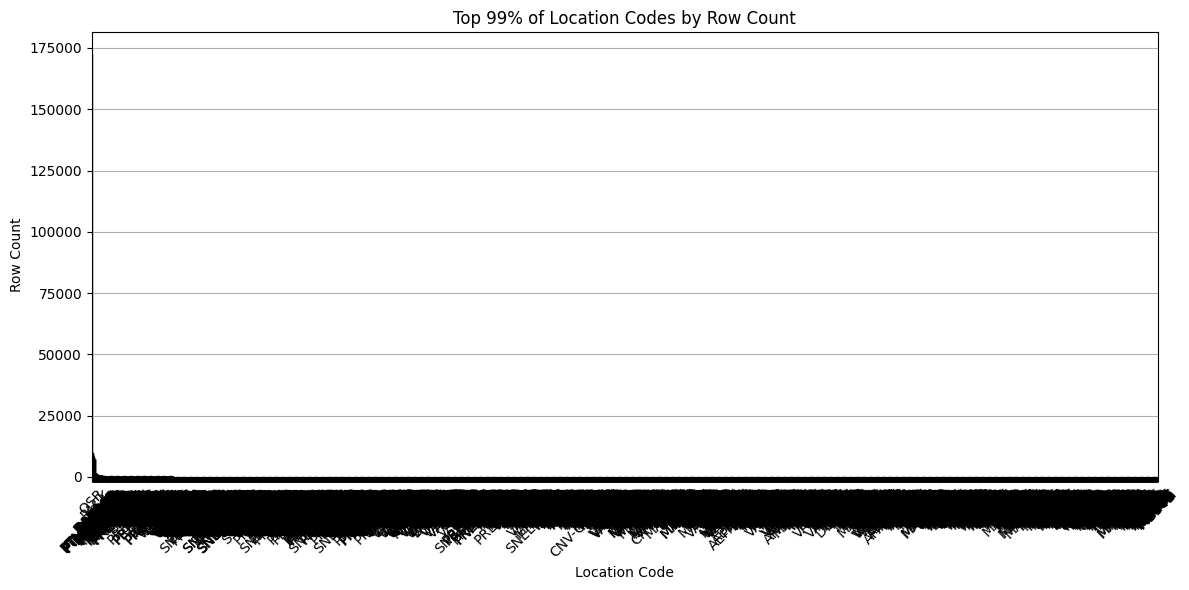

4102 location codes make up 99% of the data.


In [176]:
# Step 1: Count rows per Location code
location_counts = df['Location code'].value_counts()

# Step 2: Calculate cumulative percentage
cumulative_percent = location_counts.cumsum() / location_counts.sum()

# Step 3: Filter to keep only the top 99%
top_99 = location_counts[cumulative_percent <= 0.99] #57% voor de top 13, OSR is de grootste (37%)

# Step 4: Plot
plt.figure(figsize=(12, 6))
top_99.plot(kind='bar', color='darkorange', edgecolor='black')

plt.title('Top 99% of Location Codes by Row Count')
plt.xlabel('Location Code')
plt.ylabel('Row Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print(f"{len(top_99)} location codes make up 99% of the data.")


In [184]:
# Step 1: Compute time deltas per Location code
df_sorted = df.sort_values(by=['Location code', 'Last Change Dt'])
df_sorted['Time Delta'] = df_sorted.groupby('Location code')['Last Change Dt'].diff()

# Step 2: Convert to seconds
df_sorted['Delta Seconds'] = df_sorted['Time Delta'].dt.total_seconds()

# Step 3: Drop NaNs (first of each group) and group
mean_estimates = df_sorted.groupby('Location code')['Delta Seconds'].mean().dropna()

# Step 4: Convert mean intervals to Poisson λ
lambda_per_location = 1 / mean_estimates

print(lambda_per_location.head())


Location code
AEPACK02     0.000001
AEPACK02P    0.000001
AEPACK03     0.000010
AEPACK03P    0.000010
APACK01      0.000002
Name: Delta Seconds, dtype: float64


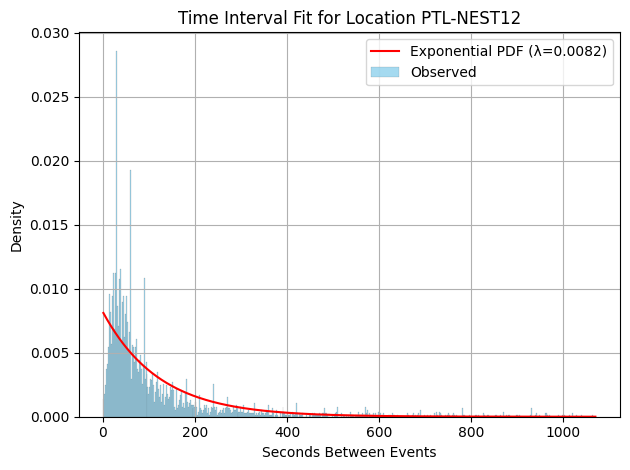

In [185]:
import seaborn as sns
import numpy as np

# Pick a location to visualize
lambda_hat = 1 / filtered_intervals.mean()

# Plot histogram with exponential fit
sns.histplot(filtered_intervals, bins=500, kde=False, stat='density', label='Observed', color='skyblue')

x = np.linspace(1, upper_bound, 500)
pdf = lambda_hat * np.exp(-lambda_hat * x)
plt.plot(x, pdf, label=f'Exponential PDF (λ={lambda_hat:.4f})', color='red')
plt.title(f"Time Interval Fit for Location {loc}")
plt.xlabel("Seconds Between Events")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
